This notebook has analysis of haplotype divergence and homozygosity in moving windows.

## Setup data

In [1]:
%run setup.ipynb
%matplotlib inline
import hapclust

In [2]:
# obtain data from unphased callset - only needed for variant annotations
callset_pass = phase1_ar31.callset_pass
pos_pass = allel.SortedIndex(callset_pass['2L/variants/POS'])
ann_pass = callset_pass['2L/variants/ANN'][:][['Annotation', 'HGVS_p']]
callset_pass

Group(/, 6)
  arrays: 1; samples
  groups: 5; 2L, 2R, 3L, 3R, X
  store: DirectoryStore

In [3]:
# setup haplotype data
callset_phased = phase1_ar31.callset_phased
genotypes_phased = allel.GenotypeDaskArray(callset_phased['2L/calldata/genotype'])
pos_phased = allel.SortedIndex(callset_phased['2L/variants/POS'])
callset_phased

<HDF5 file "ag1000g.phase1.ar3.1.haplotypes.h5" (mode r)>

In [4]:
# define region we're going to analyse
loc_region = pos_phased.locate_range(0, 5000000)
pos_phased_region = pos_phased[loc_region]
pos_phased_region

0,1,2,3,4,...,281826,281827,281828,281829,281830
44688,44691,44732,44736,44756,...,4996563,4996572,4996573,4996579,4996582


In [5]:
# locate the intersection with unphased callset - needed to tie in annotations
loc1, _ = pos_pass.locate_intersection(pos_phased_region)
np.count_nonzero(loc1)

281831

In [6]:
ann_phased_region = ann_pass[loc1]
ann_phased_region

array([(b'intergenic_region', b'.'), (b'intergenic_region', b'.'),
       (b'intergenic_region', b'.'), ..., (b'intergenic_region', b'.'),
       (b'intergenic_region', b'.'), (b'intergenic_region', b'.')], 
      dtype=[('Annotation', 'S34'), ('HGVS_p', 'S14')])

In [7]:
# exclude cross parents
haps_region = genotypes_phased[loc_region].to_haplotypes()[:, :-16].compute()
haps_region

<HaplotypeArray shape=(281831, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [8]:
# perform allele count - needed to locate singletons
ac_phased_region = haps_region.count_alleles(max_allele=1)

In [9]:
# define types of variants to include in EHH analysis - should be mostly neutral
loc_type_neutral = ((ann_phased_region['Annotation'] == b'intergenic_region') | 
                    (ann_phased_region['Annotation'] == b'intron_variant') |
                    (ann_phased_region['Annotation'] == b'downstream_gene_variant') |
                    (ann_phased_region['Annotation'] == b'upstream_gene_variant') |
                    (ann_phased_region['Annotation'] == b'synonymous_variant') |
                    (ann_phased_region['Annotation'] == b'3_prime_UTR_variant') |
                    (ann_phased_region['Annotation'] == b'5_prime_UTR_variant') 
                    )
np.count_nonzero(loc_type_neutral), loc_type_neutral.shape

(268259, (281831,))

In [10]:
# locate low frequency variants - will exclude from homozygosity analysis
loc_hf = ac_phased_region.min(axis=1) > 1
print(np.count_nonzero(loc_hf))

# these are the variants to use for haplotype homozygosity
loc_hh = loc_type_neutral & loc_hf
print(np.count_nonzero(loc_hh), loc_hh.shape)

193032
185122 (281831,)


In [11]:
haps_hh = haps_region[loc_hh]
haps_hh

<HaplotypeArray shape=(185122, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
1 1 1 1 1 ... 1 1 1 1 1
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [12]:
pos_hh = pos_phased_region[loc_hh]
pos_hh

0,1,2,3,4,...,185117,185118,185119,185120,185121
44691,44732,44756,44767,44872,...,4996563,4996572,4996573,4996579,4996582


In [17]:
#grab the npy array made in ag1000g paper 1 vgsc notebook
p1clus = np.load('../data/vgsc_cluster_membership.npy')

#make this into a dictionary

p1list = [a.decode("utf-8") for a in p1clus]
p1list = np.asarray(p1list)
nlist = list(np.unique(p1list))
vgsc_haplogroups = {n: tuple(sorted(np.nonzero(p1list == n)[0])) for n in nlist}

for k, v in vgsc_haplogroups.items():
    print(repr(k), len(v))

'' 351
'F2' 14
'S5' 36
'S1' 108
'S2' 79
'F1' 464
'S3' 165
'F4' 38
'F5' 196
'S4' 37
'F3' 42


## Setup analysis functions

In [195]:
%%cython
# cython: wraparound=False
# cython: boundscheck=False


import numpy as np 
cimport numpy as np
import scipy


cdef int pair_diffs(np.int8_t[:] h1, np.int8_t[:] h2):
    cdef:
        int i, n, v
    n = h1.shape[0]
    v = 0
    for i in range(n):
        v += (h1[i] != h2[i])
    return v
    


def pairwise_diffs_between(np.int8_t[:, :] h1, np.int8_t[:, :] h2):
    assert h1.ndim == h2.ndim == 2
    cdef:
        int i, j, n1, n2
        np.int32_t[:, :] out
    n1 = h1.shape[1]
    n2 = h2.shape[1]
    out = np.empty((n1, n2), dtype='i4')
    for i in range(n1):
        for j in range(n2):
            out[i, j] = pair_diffs(h1[:, i], h2[:, j])
    return np.asarray(out)
            

In [27]:
@functools.lru_cache(maxsize=None)
def scan_pdiffs_within(hap_ixs, startp=1500000, stopp=3500000, window_size=1000, window_step=200):
    
    # setup data
    loc = pos_hh.locate_range(startp, stopp)
    p = pos_hh[loc]
    h = np.asarray(haps_hh[loc].take(hap_ixs, axis=1), order='F')
    
    # compute in moving windows
    midpoints = allel.moving_statistic(values=p, statistic=np.mean, size=window_size, step=window_step)
    windows = list(allel.stats.window.index_windows(h, size=window_size, step=window_step, start=0, stop=None))
    result = np.array([
        allel.pairwise_distance(h[i:j], metric='hamming') * window_size
        for i, j in windows
    ], dtype=int)

    # compress result to save memory
    return midpoints, zarr.array(result)
    

In [110]:
@functools.lru_cache(maxsize=None)
def scan_pdiffs_between(hap_ixs1, hap_ixs2, startp=1500000, stopp=3500000, window_size=1000, window_step=200):
    
    # setup data
    loc = pos_hh.locate_range(startp, stopp)
    p = pos_hh[loc]
    h1 = np.asarray(haps_hh[loc].take(hap_ixs1, axis=1), order='F')
    h2 = np.asarray(haps_hh[loc].take(hap_ixs2, axis=1), order='F')
    
    # compute in moving windows
    midpoints = allel.moving_statistic(values=p, statistic=np.mean, size=window_size, step=window_step)
    windows = list(allel.stats.window.index_windows(h1, size=window_size, step=window_step, start=0, stop=None))
    result = np.array([
        pairwise_diffs_between(h1[i:j], h2[i:j]).flatten()
        for i, j in windows
    ], dtype=int)

    # compress result to save memory
    return midpoints, zarr.array(result)
    

In [47]:
rcParams['figure.dpi'] = 120

In [175]:
palette = sns.color_palette()
region_vgsc = SeqFeature('2L', 2358158, 2431617)


def plot_pdiffs_within(hap_ixs, startp=1500000, stopp=3500000, window_size=1000, window_step=200, n_boot=10, ax=None):
    
    # get data
    midpoints, pdiffs = scan_pdiffs_within(hap_ixs, startp=startp, stopp=stopp, window_size=window_size, window_step=window_step)
    pdiffs = pdiffs[:]

    # broadcast out X coords
    x = np.empty(pdiffs.shape, dtype=int)
    x[:] = midpoints[:, None].astype(int)

    # plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 3))
        sns.despine(ax=ax, offset=5)
    ax.axvline(region_vgsc.start, linestyle='--', color='k')
    ax.axvline(region_vgsc.end, linestyle='--', color='k')
    mx = x[:, 0]
    my = pdiffs.mean(axis=1)
    ax.plot(mx, my, color='k')
    sns.regplot(x=x.flatten(), y=pdiffs.flatten(), n_boot=n_boot, scatter=True, fit_reg=False, 
                x_estimator=np.mean, ax=ax, color='k', scatter_kws=dict(s=10))
    ax.set_ylim(bottom=-1)
    ax.set_ylabel('Mean no. SNP differences')
    ax.set_xlabel('Position (bp)')
    ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks()])
    ax.text((region_vgsc.start + region_vgsc.end)/2, ax.get_ylim()[1], 'Vgsc', ha='center', va='bottom', fontstyle='italic', fontsize=8)
    if fig is not None:
        fig.tight_layout()
    
    
def plot_hh_within(hap_ixs, startp=1500000, stopp=3500000, window_size=1000, window_step=200, n_boot=0, ax=None, threshold=1, markersize=5, label=None):
    
    # get data
    midpoints, pdiffs = scan_pdiffs_within(hap_ixs, startp=startp, stopp=stopp, window_size=window_size, window_step=window_step)
    pdiffs = pdiffs[:]

    # broadcast out X coords
    x = np.empty(pdiffs.shape, dtype=int)
    x[:] = midpoints[:, None].astype(int)

    # plot
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 3))
        sns.despine(ax=ax, offset=5)
    ax.axvline(region_vgsc.start, linestyle='--', color='k')
    ax.axvline(region_vgsc.end, linestyle='--', color='k')
    mx = x[:, 0]
    my = (pdiffs <= threshold).sum(axis=1) / pdiffs.shape[1]
    ax.plot(mx, my, color='k', label=label)
    sns.regplot(x=x.flatten(), y=pdiffs.flatten(), n_boot=n_boot, scatter=True, fit_reg=False, 
                x_estimator=lambda v: (np.sum(v <= threshold)) / len(v), ax=ax, color='k',
                scatter_kws=dict(s=markersize))
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticklabels(['{:.1f}'.format(x/1e6) for x in ax.get_xticks()])
    if fig is not None:
        ax.text((region_vgsc.start + region_vgsc.end)/2, ax.get_ylim()[1], 'Vgsc', ha='center', va='bottom', fontstyle='italic', fontsize=8)
        ax.set_ylabel('Haplotype homozygosity')
        ax.set_xlabel('Position (Mbp)')
        fig.tight_layout()
    
    
def plot_hh_between(hap_ixs1, hap_ixs2, startp=1500000, stopp=3500000, window_size=1000, window_step=200, n_boot=0, ax=None, threshold=1, markersize=5, label=None):
    
    # get data
    midpoints, pdiffs = scan_pdiffs_between(hap_ixs1, hap_ixs2, startp=startp, stopp=stopp, window_size=window_size, window_step=window_step)
    pdiffs = pdiffs[:]

    # broadcast out X coords
    x = np.empty(pdiffs.shape, dtype=int)
    x[:] = midpoints[:, None].astype(int)

    # plot
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 3))
        sns.despine(ax=ax, offset=5)
    ax.axvline(region_vgsc.start, linestyle='--', color='k')
    ax.axvline(region_vgsc.end, linestyle='--', color='k')
    mx = x[:, 0]
    my = (pdiffs <= threshold).sum(axis=1) / pdiffs.shape[1]
    ax.plot(mx, my, color='k', label=label)
    sns.regplot(x=x.flatten(), y=pdiffs.flatten(), n_boot=n_boot, scatter=True, fit_reg=False, 
                x_estimator=lambda v: (np.sum(v <= threshold)) / len(v), ax=ax, color='k',
                scatter_kws=dict(s=markersize))
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticklabels(['{:.1f}'.format(x/1e6) for x in ax.get_xticks()])
    if fig is not None:
        ax.text((region_vgsc.start + region_vgsc.end)/2, ax.get_ylim()[1], 'Vgsc', ha='center', va='bottom', fontstyle='italic', fontsize=8)
        ax.set_ylabel('Haplotype homozygosity')
        ax.set_xlabel('Position (Mbp)')
        fig.tight_layout()
    

In [191]:
sns.set_style('white')
sns.set_style('ticks')

## Make plots

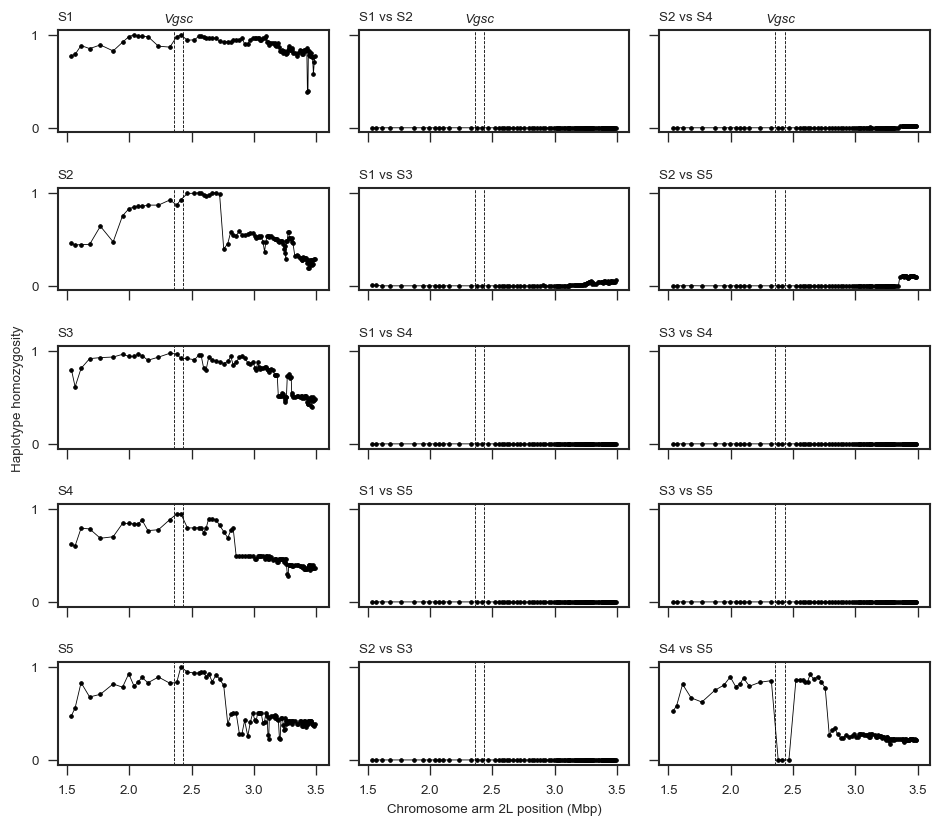

In [193]:
window_size = 1000
window_step = 500
fig, axs = plt.subplots(nrows=5, ncols=3, sharex=True, sharey=True, figsize=(8, 7))
for i in range(5):
    ax = axs[i, 0]
    g = 'S%s' % (i + 1)
    plot_hh_within(vgsc_haplogroups[g], window_size=window_size, window_step=window_step, ax=ax, label=g)
    ax.set_title(g, loc='left')
    ax.set_yticks([0, 1])
#     ax.text(.98, .95, g, ha='right', va='top', transform=ax.transAxes, fontsize=8, fontweight='bold')

combinations = list(itertools.combinations(range(1, 6), 2))
axes_ixs = [(i, j) for j in range(1, 3) for i in range(5)]
for (c1, c2), axes_ix in zip(combinations, axes_ixs):
    ax = axs[axes_ix]
    g1 = 'S%s' % c1
    g2 = 'S%s' % c2
    label = '%s vs %s' % (g1, g2)
    plot_hh_between(vgsc_haplogroups[g1], vgsc_haplogroups[g2], window_size=window_size, window_step=window_step, ax=ax, label=label)
    ax.set_title(label, loc='left')
    ax.set_yticks([0, 1])
#     ax.text(.98, .95, label, ha='right', va='top', transform=ax.transAxes, fontsize=8, fontweight='bold')
    
# annotations
for i in range(3):
    axs[0, i].text((region_vgsc.start + region_vgsc.end)/2, 1.1, 'Vgsc', ha='center', va='bottom', fontstyle='italic', fontsize=8)
axs[2, 0].set_ylabel('Haplotype homozygosity')
axs[-1, 1].set_xlabel('Chromosome arm 2L position (Mbp)')

fig.tight_layout()

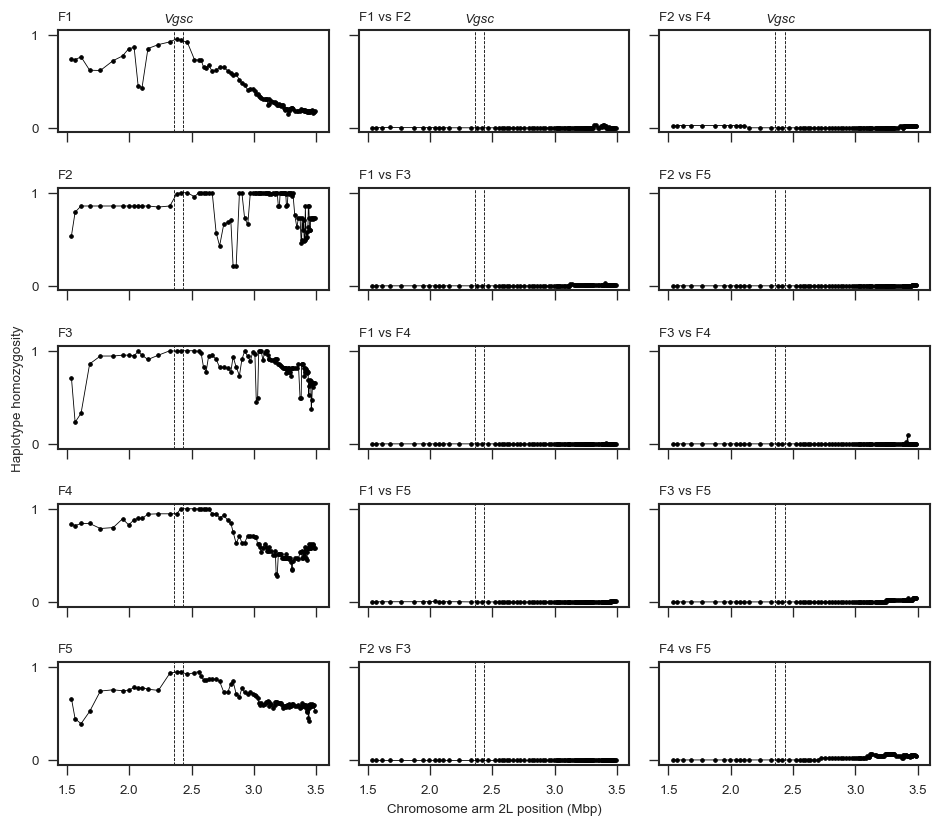

In [194]:
window_size = 1000
window_step = 500
fig, axs = plt.subplots(nrows=5, ncols=3, sharex=True, sharey=True, figsize=(8, 7))
for i in range(5):
    ax = axs[i, 0]
    g = 'F%s' % (i + 1)
    plot_hh_within(vgsc_haplogroups[g], window_size=window_size, window_step=window_step, ax=ax, label=g)
    ax.set_title(g, loc='left')
    ax.set_yticks([0, 1])
#     ax.text(.98, .95, g, ha='right', va='top', transform=ax.transAxes, fontsize=8, fontweight='bold')

combinations = list(itertools.combinations(range(1, 6), 2))
axes_ixs = [(i, j) for j in range(1, 3) for i in range(5)]
for (c1, c2), axes_ix in zip(combinations, axes_ixs):
    ax = axs[axes_ix]
    g1 = 'F%s' % c1
    g2 = 'F%s' % c2
    label = '%s vs %s' % (g1, g2)
    plot_hh_between(vgsc_haplogroups[g1], vgsc_haplogroups[g2], window_size=window_size, window_step=window_step, ax=ax, label=label)
    ax.set_title(label, loc='left')
    ax.set_yticks([0, 1])
#     ax.text(.98, .95, label, ha='right', va='top', transform=ax.transAxes, fontsize=8, fontweight='bold')
    
# annotations
for i in range(3):
    axs[0, i].text((region_vgsc.start + region_vgsc.end)/2, 1.1, 'Vgsc', ha='center', va='bottom', fontstyle='italic', fontsize=8)
axs[2, 0].set_ylabel('Haplotype homozygosity')
axs[-1, 1].set_xlabel('Chromosome arm 2L position (Mbp)')

fig.tight_layout()